## Automatic Ticket Classification

 - Build a model to classify the customer complaints based on products/services. So the tickets can be aggregated into their relevant categories and provide quick resolution of the issue.

In [1]:
import json 
import numpy as np
import pandas as pd

#### Read the data from JSON file

In [2]:
fp = open("complaints-2021-05-14_08_16.json")

In [3]:
complaint_data = json.load(fp)

In [4]:
complaint_data[0]

{'_index': 'complaint-public-v2',
 '_type': 'complaint',
 '_id': '3211475',
 '_score': 0.0,
 '_source': {'tags': None,
  'zip_code': '90301',
  'complaint_id': '3211475',
  'issue': 'Attempts to collect debt not owed',
  'date_received': '2019-04-13T12:00:00-05:00',
  'state': 'CA',
  'consumer_disputed': 'N/A',
  'product': 'Debt collection',
  'company_response': 'Closed with explanation',
  'company': 'JPMORGAN CHASE & CO.',
  'submitted_via': 'Web',
  'date_sent_to_company': '2019-04-13T12:00:00-05:00',
  'company_public_response': None,
  'sub_product': 'Credit card debt',
  'timely': 'Yes',
  'complaint_what_happened': '',
  'sub_issue': 'Debt is not yours',
  'consumer_consent_provided': 'Consent not provided'}}

In [5]:
comp_df = pd.json_normalize(complaint_data)

In [6]:
print(comp_df.shape, "\n")
print(comp_df.dtypes)

(78313, 22) 

_index                                object
_type                                 object
_id                                   object
_score                               float64
_source.tags                          object
_source.zip_code                      object
_source.complaint_id                  object
_source.issue                         object
_source.date_received                 object
_source.state                         object
_source.consumer_disputed             object
_source.product                       object
_source.company_response              object
_source.company                       object
_source.submitted_via                 object
_source.date_sent_to_company          object
_source.company_public_response       object
_source.sub_product                   object
_source.timely                        object
_source.complaint_what_happened       object
_source.sub_issue                     object
_source.consumer_consent_provided     obj

### Data preparation

In [7]:
print(comp_df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [8]:
column_name = ['index', 'type', 'id', 'score', 'source', 'zip_code', 'complaint_id', 'issue', 'date_received', 
                          'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 
                          'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 
                          'sub_issue', 'consumer_consent_provided']
comp_df.columns = column_name

In [9]:
comp_df.head(2)

,index,type,id,score,source,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided


In [10]:
comp_df['complaint_what_happened'] = comp_df['complaint_what_happened'].replace("", np.NAN)

In [11]:
comp_df.isna().sum()

index                            0
type                             0
id                               0
score                            0
source                       67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened      57241
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [12]:
comp_df2 = comp_df.drop(labels=['source', 'company_public_response'], axis = 1)

In [13]:
comp_df2 = comp_df2.dropna()

In [14]:
comp_df2.reset_index(inplace = True)

In [15]:
comp_df2.shape

(10123, 21)

### Prepare Topic Modelling

In [16]:
# Clean the text and remove all the unnecessary elements.
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
import re
import nltk 
import spacy

import matplotlib.pyplot as plt
from wordcloud import WordCloud

stop = stopwords.words('english')
pattern = '[a-zA-Z]+'

complaints = {}
complaints_msg = []

for index, row in comp_df2.iterrows():
    complaints[row['complaint_id']] = row['complaint_what_happened']
    complaints_msg.append(row['complaint_what_happened'])
    
for k in complaints:
    complaint = re.findall(pattern, complaints[k].lower())
    complaint = ' '.join(complaint)
    complaints[k] = complaint

2023-04-18 21:41:21.744034: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
# Lemmatize the texts
word_lemmatizer = WordNetLemmatizer()

complaints_lemmatized = []

for cid in complaints:
    complaint = complaints[cid]
    #print(complaint)

    tokens = nltk.tokenize.word_tokenize(complaint)
    token_lemma = [word_lemmatizer.lemmatize(token) for token in tokens]
    token_lemma_without_stop = [word for word in token_lemma if word not in (stop)]
    complaints_lemmatized.append(' '.join(token_lemma_without_stop))

df_clean = pd.DataFrame({'complaint_id': complaints.keys(), 'complaint_what_happened' : complaints_msg,
                         'complaint_processed' : complaints.values(), 'complaint_lemmatized' :complaints_lemmatized})

In [18]:
nlp = spacy.load('en_core_web_sm')

In [19]:
# To extract the POS tags
from tqdm import tqdm

complaint_pos = []
for index, row in tqdm(df_clean.iterrows()):
    sentence = row['complaint_lemmatized']
    
    tokens = nlp(sentence)
    pos_tag = []
    for token in tokens:
        #print(token.text, "--", token.pos_, "--", token.tag_)
        if token.tag_ == 'NN':
            pos_tag.append(token.text)
    complaint_pos.append(' '.join(pos_tag))    

df_clean['complaint_POS_removed'] = complaint_pos

10123it [02:39, 63.48it/s]


### Exploratory Data Analysis

In [20]:
def generate_complaint_words(df, column):
    complaint_words = []
    for index, row in df.iterrows():
        complaint = row[column]
        for word in complaint.split(' '):
            complaint_words.append(word)
    return complaint_words

In [21]:
text = ' '.join(generate_complaint_words(df_clean, 'complaint_POS_removed'))

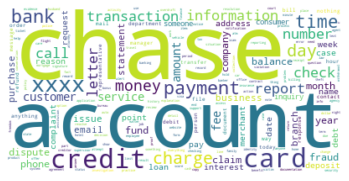

In [22]:
# install Word clould package using 'pip install wordcloud' command
def draw_word_cloud(word_text):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(word_text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
draw_word_cloud(text)

In [23]:
#### the top 40 words by frequency among all the articles after processing the text.
top_words = pd.Series(text.split())
top_words.value_counts().head(40)

chase          24872
account        23573
credit         17871
card           17475
xxxx           12430
payment         8051
bank            8049
time            7605
charge          6901
day             6620
money           5501
information     4759
transaction     4555
report          4503
check           4476
number          4399
letter          4293
call            4168
customer        4140
fee             4135
service         3847
amount          3781
dispute         3771
claim           3717
phone           3678
balance         3637
fraud           3595
month           3576
company         3498
fund            3397
year            3393
business        2805
email           2770
issue           2591
purchase        2550
statement       2487
branch          2469
deposit         2297
loan            2151
date            2133
dtype: int64

In [24]:
def get_ngram(text, n, top_n_word):
    ngram_word = ngrams(text.split(), n)

    ngram_word_order = pd.Series(ngram_word)
    return ngram_word_order.value_counts().head(top_n_word)

In [25]:
# Print the top 10 words in the unigram frequency
print(get_ngram(text, 1, 10))

(chase,)      24872
(account,)    23573
(credit,)     17871
(card,)       17475
(xxxx,)       12430
(payment,)     8051
(bank,)        8049
(time,)        7605
(charge,)      6901
(day,)         6620
dtype: int64


In [26]:
# Print the top 10 words in the bigram frequency
print(get_ngram(text, 2, 10))

(credit, card)         7104
(credit, report)       2290
(chase, credit)        1747
(account, chase)       1607
(customer, service)    1572
(account, account)     1360
(chase, account)       1260
(debit, card)          1217
(chase, bank)          1173
(card, chase)          1080
dtype: int64


In [27]:
# Print the top 10 words in the trigram frequency
print(get_ngram(text, 3, 10))

(chase, credit, card)        1303
(credit, card, account)       656
(credit, card, chase)         497
(credit, card, company)       491
(inquiry, credit, report)     366
(xxxx, xxxx, xxxx)            353
(xxxx, credit, card)          339
(credit, card, credit)        281
(account, credit, card)       263
(card, credit, card)          226
dtype: int64


#### Customer personal details is masked with xxxx in the dataset. Let's remove the xxxx masked text, since there is no use for the analysis

In [28]:
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

In [29]:
df_clean.head()

,complaint_id,complaint_what_happened,complaint_processed,complaint_lemmatized,complaint_POS_removed,complaint_clean
0,3229299,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...
1,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xx xx and was ...,upgraded xxxx xxxx card xx xx wa told agent up...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
2,3233499,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xx xx however fraud...,chase card wa reported xx xx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...
3,3180294,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while trying to book a xxxx xxxx tick...,xx xx trying book xxxx xxxx ticket came across...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...
4,3224980,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...,son check deposit chase account fund account m...


### Feature Extraction

In [30]:
# Initialise the TfidfVectorizer 
complaint_clean_words = []
for index, row in df_clean.iterrows():
        complaint_clean_words.append(row['complaint_clean'])

from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(stop_words='english')

In [31]:
X = vect.fit_transform(complaint_clean_words)

In [32]:
pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())

,aa,aaa,aacount,aarp,abeyance,abhorrent,abide,ability,abnormality,aborad,...,yyyy,zeal,zeroed,zilch,zip,zipcode,zombie,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Topic Modelling using NMF

In [33]:
from sklearn.decomposition import NMF

In [34]:
NUM_TOPICS = 5

nmf = NMF(n_components=NUM_TOPICS)
W = nmf.fit_transform(X)     # Document - Topic matrix
H = nmf.components_          # Topic - Term matric

In [35]:
words = np.array(vect.get_feature_names_out())
column = 20
topic_words = pd.DataFrame(np.zeros((NUM_TOPICS, column)), index=[f'Topic {i + 1}' for i in range(NUM_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(column)]).astype(str)
for i in range(NUM_TOPICS):
    ix = H[i].argsort()[::-1][:column]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20
Topic 1,card,credit,chase,account,year,score,balance,limit,point,application,month,reason,letter,offer,time,purchase,freedom,company,customer,use
Topic 2,inquiry,report,credit,company,information,reporting,identity,theft,authorization,proof,bureau,knowledge,file,letter,application,creditor,date,verification,consumer,purpose
Topic 3,account,check,money,bank,fund,chase,deposit,branch,day,fee,business,number,checking,reason,time,customer,balance,transfer,access,information
Topic 4,payment,loan,balance,month,fee,statement,time,credit,auto,day,chase,date,report,company,car,mortgage,error,pay,debt,year
Topic 5,charge,chase,dispute,transaction,claim,fraud,merchant,purchase,email,letter,time,service,information,day,number,refund,card,phone,company,item


### Manual Topic Modeling

In [36]:
topic_mapping = {
    'Topic 1': 'Credit card or prepaid card',
    'Topic 2': 'Theft/Dispute Reporting',
    'Topic 3': 'Bank Account services',
    'Topic 4': 'Mortgage/Loan', 
    'Topic 5': 'Others'
}

In [37]:
# Assign the best topic to each complaint in 'Topic' column

W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(NUM_TOPICS)])
df_clean['Topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
df_clean[pd.notnull(df_clean['Topic'])].head(10)

,complaint_id,complaint_what_happened,complaint_processed,complaint_lemmatized,complaint_POS_removed,complaint_clean,Topic
0,3229299,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...,Bank Account services
1,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xx xx and was ...,upgraded xxxx xxxx card xx xx wa told agent up...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit card or prepaid card
2,3233499,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xx xx however fraud...,chase card wa reported xx xx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...,Credit card or prepaid card
3,3180294,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while trying to book a xxxx xxxx tick...,xx xx trying book xxxx xxxx ticket came across...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,Credit card or prepaid card
4,3224980,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...,son check deposit chase account fund account m...,Bank Account services
5,3331023,With out notice J.P. Morgan Chase restricted m...,with out notice j p morgan chase restricted my...,notice j p morgan chase restricted account deb...,account debit card branch customer service rep...,account debit card branch customer service rep...,Bank Account services
6,3352857,"During the summer months, I experience a decli...",during the summer months i experience a declin...,summer month experience decline income due emp...,summer month experience decline income employm...,summer month experience decline income employm...,Mortgage/Loan
7,3237765,I have a Chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card credit report company issue,chase credit card credit report company issue,Credit card or prepaid card
8,3200018,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto xxxx,account chase auto,Bank Account services
9,3200365,I opened an account with chase bank on XXXX an...,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account bonus follow term everything account d...,account bonus follow term everything account d...,Bank Account services


In [38]:
# Print the first 5 complaint for each of the Topic
df_clean2 = df_clean.groupby('Topic').head(5)
df_clean2.sort_values('Topic')

,complaint_id,complaint_what_happened,complaint_processed,complaint_lemmatized,complaint_POS_removed,complaint_clean,Topic
0,3229299,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase debt verification statement...,morning name chase debt verification statement...,Bank Account services
4,3224980,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,grand son give check deposit chase account fun...,son check deposit chase account fund account m...,son check deposit chase account fund account m...,Bank Account services
5,3331023,With out notice J.P. Morgan Chase restricted m...,with out notice j p morgan chase restricted my...,notice j p morgan chase restricted account deb...,account debit card branch customer service rep...,account debit card branch customer service rep...,Bank Account services
8,3200018,mishandling of this account by Chase auto and ...,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto xxxx,account chase auto,Bank Account services
9,3200365,I opened an account with chase bank on XXXX an...,i opened an account with chase bank on xxxx an...,opened account chase bank xxxx used code xxxx ...,account bonus follow term everything account d...,account bonus follow term everything account d...,Bank Account services
1,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in xx xx and was ...,upgraded xxxx xxxx card xx xx wa told agent up...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Credit card or prepaid card
2,3233499,Chase Card was reported on XX/XX/2019. However...,chase card was reported on xx xx however fraud...,chase card wa reported xx xx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...,Credit card or prepaid card
3,3180294,"On XX/XX/2018, while trying to book a XXXX XX...",on xx xx while trying to book a xxxx xxxx tick...,xx xx trying book xxxx xxxx ticket came across...,book ticket offer ticket reward card informati...,book ticket offer ticket reward card informati...,Credit card or prepaid card
7,3237765,I have a Chase credit card which is incorrectl...,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card credit report company issue,chase credit card credit report company issue,Credit card or prepaid card
11,3236849,My chase amazon card was declined for a cateri...,my chase amazon card was declined for a cateri...,chase amazon card wa declined catering order p...,catering order brother funeral amount chase no...,catering order brother funeral amount chase no...,Credit card or prepaid card


#### After mapping, check whether the topic assigned is correct and the names is relevant to the topic.

In [39]:
n_row = 1501
print(df_clean.iloc[n_row].complaint_what_happened)
print("\n")
print(df_clean.iloc[n_row].Topic)

I currently have two credit cards with CHASE, of which I am trying to pay off the balance, unfortunately, I lost my employment and income for a few months, and subsequently had to use my available credit. I have made my minimum monthly payments, however, the interest rate fees are extremely high. On one card Chase/XXXX, the monthly interest fees are no less than {$20.00} ( last statement was {$22.00} ). The second card Chase/Freedom, the monthly interest rate is also no less than {$20.00} ( on my last check, {$26.00}. I have attempted to find out if there are any other options than the current one they offer for Covid 19 Financial Relief, however, it does not mak any sense at all, when payments can be differed, but interest rates continue to get charged monthly, and they still report to the credit bureaus. How can charging interest and affecting your credit be of any assistance? -- I was able to get on a payment plan with XXXX XXXX making a minimum monthly payment and no finance charge

In [40]:
len(df_clean)

10123

### Apply supervised model to predict any new complaints and relevant topic

In [41]:
Topic_names = {
    'Credit card or prepaid card' : 1,
    'Theft/Dispute Reporting'     : 2,
    'Bank Account services'       : 3,
    'Mortgage/Loan'               : 4, 
    'Others'                      : 5
}

#Replace Topics with Topic Names
df_clean['Topic_numeric'] = df_clean['Topic'].map(Topic_names)

In [42]:
training_data = pd.DataFrame({'complaint_what_happened' : df_clean['complaint_what_happened'],
                              'Topic_numeric' : df_clean['Topic_numeric'],})

In [43]:
training_data.head()

,complaint_what_happened,Topic_numeric
0,Good morning my name is XXXX XXXX and I apprec...,3
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
2,Chase Card was reported on XX/XX/2019. However...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",1
4,my grand son give me check for {$1600.00} i de...,3


In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corpus = training_data['complaint_what_happened'].tolist()

CntVectorizer = CountVectorizer()
CntVectData = CntVectorizer.fit_transform(corpus)
#CntVectorizer.get_feature_names_out()

In [45]:
#print(CntVectData.toarray())
CntVectData.shape

(10123, 20040)

In [46]:
# Transform the word vector to tf-idf
X = vect.fit_transform(corpus)

In [47]:
y = training_data['Topic_numeric']

In [48]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [49]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(7086, 19734) (3037, 19734)
(7086,) (3037,)


### Logistic Regression

In [50]:
feature_cols = ['Credit card or prepaid card', 'Theft/Dispute Reporting', 'Bank Account services', 'Mortgage/Loan', 'Others']

In [51]:
logreg = LogisticRegression(solver='liblinear', random_state=RANDOM_STATE, max_iter=10)

In [52]:
# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

y_proba = logreg.predict_proba(X_test)

In [53]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

In [54]:
print(classification_report(y_test, y_pred, target_names=feature_cols))

                             precision    recall  f1-score   support

Credit card or prepaid card       0.89      0.87      0.88       553
    Theft/Dispute Reporting       0.94      0.83      0.88       311
      Bank Account services       0.90      0.96      0.93       915
              Mortgage/Loan       0.94      0.86      0.90       476
                     Others       0.90      0.95      0.92       782

                   accuracy                           0.91      3037
                  macro avg       0.92      0.89      0.90      3037
               weighted avg       0.91      0.91      0.91      3037



In [55]:
classes = logreg.classes_
print(metrics.roc_auc_score(y_test, y_proba, labels = classes, multi_class = 'ovr', average = 'macro'))

0.991134740214


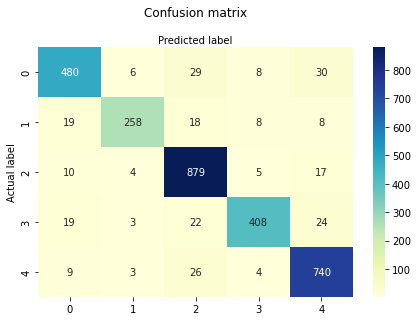

In [57]:

fig, ax = plt.subplots()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

### Decision Tree

In [58]:
DecisionTree = DecisionTreeClassifier(criterion="entropy", random_state=RANDOM_STATE)

# Train Decision Tree Classifer
dectree = DecisionTree.fit(X_train, y_train)

#Predict the response for test dataset
y_pred2 = dectree.predict(X_test)

y_proba2 = dectree.predict_proba(X_test)

In [59]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred2)
print(classification_report(y_test, y_pred2, target_names=feature_cols))

                             precision    recall  f1-score   support

Credit card or prepaid card       0.71      0.73      0.72       553
    Theft/Dispute Reporting       0.81      0.72      0.77       311
      Bank Account services       0.81      0.82      0.81       915
              Mortgage/Loan       0.77      0.80      0.79       476
                     Others       0.73      0.72      0.73       782

                   accuracy                           0.76      3037
                  macro avg       0.77      0.76      0.76      3037
               weighted avg       0.76      0.76      0.76      3037



In [60]:
classes = dectree.classes_
print(metrics.roc_auc_score(y_test, y_proba2, labels = classes, multi_class = 'ovr', average = 'macro'))

0.8486162370898718


### Random Forest

In [61]:
RandomClassiier = RandomForestClassifier(n_estimators = 50, criterion = 'gini', random_state=RANDOM_STATE)

RandomClassiier.fit(X_train, y_train)

y_pred3 = RandomClassiier.predict(X_test)

y_proba3 = RandomClassiier.predict_proba(X_test)

In [62]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred3)
print(classification_report(y_test, y_pred3, target_names=feature_cols))

                             precision    recall  f1-score   support

Credit card or prepaid card       0.74      0.74      0.74       553
    Theft/Dispute Reporting       0.90      0.74      0.81       311
      Bank Account services       0.80      0.93      0.86       915
              Mortgage/Loan       0.87      0.71      0.78       476
                     Others       0.83      0.83      0.83       782

                   accuracy                           0.81      3037
                  macro avg       0.83      0.79      0.80      3037
               weighted avg       0.82      0.81      0.81      3037



In [63]:
classes = RandomClassiier.classes_
print(metrics.roc_auc_score(y_test, y_proba3, labels = classes, multi_class = 'ovr', average = 'macro'))

0.9675912896259034


## Summary

 - Evaluated this data on all 3 models i.e. Logistic Regression, Decision Tree and Random Forest and analyased for various precision, recall, F1 score and ROC curve meterics. 
 - Got an optimistic prediction result of 91% and 99% respectively in weighted average F1 score and ROC curve for logistic regression. 
 - Logistic regression gives better results over other models for this data.